# Text2Scene
Dies ist die Lösung der Fingerübung für das Praktikum Text2Scene des Sommersemesters 2021

Autor: Xuan Anh Nguyen <br>
Email: xuananh6077@stud.uni-frankfurt.de

In [1]:
import numpy
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
import spacy
import networkx as nx
import xml.etree.ElementTree as ET
import itertools
import os
import pathlib
import random
from tqdm import tqdm
from spacy.training import Example


In [2]:
def count_pos(ls):
     x_set = set(ls)
     x_dict = {}

     for entry in x_set:
          x_dict[entry] = ls.count(entry)

     return x_dict

## Aufgabe 2.2 Vorverarbeitung
Einlesen der Trainingsdaten sowie Training des Models mit dem NLP Paket **SpaCy**


In [3]:
# read all valid files used for training

train_data = [] # save only valid data for training (i.e. important tags)
full_data = [] # save all (xml) data
poss_tags = []

root = pathlib.Path().absolute()
for subdir, dirs, files in os.walk(root):
    # skip all hidden directories and files
    files = [f for f in files if not f[0] == '.']
    dirs[:] = [d for d in dirs if not d[0] == '.']
    if not subdir.startswith('.'):
        for filename in files:
            filepath = subdir + os.sep + filename
            if filepath.endswith(".xml"):
                # filepath will now point towards a valid .xml file
                
                # read and parse xml files
                tree = ET.parse(filepath)
                root = tree.getroot()
                
                full_data.append(root)
                
                # label text with entities 
                entities = []
                for elem in root[1]:
                    # filter non usable entries
                    if (elem.get('start') != None) and (elem.get('end') != None) and (elem.get('start') != '-1') and (elem.get('end') != '-1'):
                        new_ent = (int(elem.get('start')), int(elem.get('end')), elem.tag)
                        entities.append(new_ent)
                    if elem.tag not in poss_tags:
                        poss_tags.append(elem.tag)
                        
                # save the 2 special xml files extra so we can access them easier later
                if filepath.endswith("Bicycles.xml"):
                    print("confirmed")
                    special1 = root
                elif filepath.endswith("Highlights_of_the_Prado_Museum.xml"):
                    print("confirmed")
                    special2 = root

                        
                train_data.append((root[0].text, {'entities': entities}))
    
# print(TRAIN_DATA[1][0])
print(poss_tags)

confirmed
confirmed
['PLACE', 'PATH', 'SPATIAL_ENTITY', 'NONMOTION_EVENT', 'MOTION', 'SPATIAL_SIGNAL', 'MOTION_SIGNAL', 'MEASURE', 'QSLINK', 'OLINK', 'MOVELINK', 'MLINK', 'METALINK', 'MEASURELINK', 'CP', 'URL']


In [4]:
# train the model with our training data

model = "en_core_web_sm"
n_iter = 1000

if model is not None:
    nlp = spacy.load(model) 
    print("Loaded model '%s'" % model)
else:
    nlp = spacy.blank('en')  
    print("Created blank 'en' model")


if 'ner' not in nlp.pipe_names:
    nlp.add_pipe('ner', last=True)
if 'tok2vec' not in nlp.pipe_names:
    nlp.add_pipe('tok2vec', last=True)
if 'tagger' not in nlp.pipe_names:
    nlp.add_pipe('tagger', last=True)
if 'parser' not in nlp.pipe_names:
    nlp.add_pipe('parser', last=True)
if 'sentencizer' not in nlp.pipe_names:
    nlp.add_pipe('sentencizer', last=True)


ner = nlp.get_pipe('ner')

for _, annotations in train_data:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])
     
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
with nlp.disable_pipes(*other_pipes):  # only train NER
    # optimizer = nlp.begin_training()
    for itn in range(n_iter):
        random.shuffle(train_data)
        losses = {}
        doc = nlp.make_doc(root[0].text)
        for text, annotations in train_data:
            try:
                nlp.update(
                    [Example.from_dict(nlp.make_doc(text), annotations)],  
                    drop=0.4,  
                    # sgd=optimizer,
                    losses=losses)
            except:
                pass
        print('\rEpisode {}\tLosses: {:.2f}'.format(itn, losses['ner']), end="")

# nlp.to_disk(root+"/my_model")

Loaded model 'en_core_web_sm'


/home/xa/.local/lib/python3.8/site-packages/spacy/training/iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "

23-Aug-2002 -- On 23-August-2002 at 8 am we left..." with entities "[(1006, 1011, 'PLACE'), (1058, 1063, 'PLACE'), (12...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/xa/.local/lib/python3.8/site-packages/spacy/training/iob_utils.py:139: UserWarning: [W030] Some entities could not be aligned in the text "
Cartagena and the Colombian Presidential Election..." with entities "[(158, 166, 'PLACE'), (2026, 2032, 'PLACE'), (2080...". Use `spacy.training.offsets_to_biluo_tags(nlp.make_doc(text), entities)` to check the alignment. Misaligned entities ('-') will be ignored during training.
  warnings.warn(
/home/xa/.local/lib/python3.8/site-packages/spacy/training/iob_utils.py:139: UserWarning: [W030] Some entities c

Episode 999	Losses: 89.442

In [ ]:
# Alternatively just load pretrained English tokenizer, tagger, parser and NER
nlp = spacy.load("en_core_web_sm")

## 2.3 Auswertung

Wie oft kommen welche PoS-Tags vor?

In [5]:
pos = []
for text, _ in train_data:
    doc = nlp(text)
    for token in doc:
        pos.append(token.pos_)
pos = count_pos(pos)
print("Aufgabe 1:")
print(*pos.items(), sep="\n")
    

Aufgabe 1:
('PUNCT', 3508)
('NOUN', 5180)
('ADP', 3105)
('VERB', 2927)
('NUM', 629)
('PRON', 1627)
('SCONJ', 299)
('CCONJ', 826)
('AUX', 897)
('X', 25)
('INTJ', 12)
('PART', 518)
('SPACE', 825)
('SYM', 23)
('DET', 2951)
('ADJ', 1828)
('PROPN', 1927)
('ADV', 1315)


Wie viele [SpatialEntities, Places, Motions, Locations, Signals, QsLinks, OLinks] gibt es?

In [6]:
# From xml data
ents = []
for data in full_data:
    for elem in data[1]:
         ents.append(elem.tag)

ents = count_pos(ents)
print("Aufgabe 2:")
print(*ents.items(), sep="\n")

Aufgabe 2:
('MEASURE', 170)
('URL', 17)
('SPATIAL_ENTITY', 1417)
('CP', 17)
('MOTION', 771)
('METALINK', 1788)
('PLACE', 1852)
('QSLINK', 970)
('OLINK', 244)
('MLINK', 42)
('MEASURELINK', 93)
('PATH', 434)
('MOVELINK', 803)
('NONMOTION_EVENT', 341)
('MOTION_SIGNAL', 526)
('SPATIAL_SIGNAL', 714)


In [7]:
# From processing the texts with spacy, after training with own data
# Not all data could be fed e.g. QSLinks and Olinks
ents2 = []
for text, _ in train_data:
    doc = nlp(text)
    for ent in doc.ents:
         ents2.append(ent.label_)

ents2 = count_pos(ents2)
print("Aufgabe 2:")
print(*ents2.items(), sep="\n")

Aufgabe 2:
('MEASURE', 162)
('SPATIAL_ENTITY', 1326)
('MOTION', 770)
('PLACE', 1600)
('PATH', 406)
('NONMOTION_EVENT', 340)
('MOTION_SIGNAL', 520)
('SPATIAL_SIGNAL', 687)


Wie oft kommen welche QsLink Typen vor? (DC,EC, ...)?

In [8]:
links = []
for data in full_data:
    for elem in data[1]:
        if elem.tag == "QSLINK":
            links.append(elem.get('relType'))
            
links = count_pos(links)
print("Aufgabe 3:")
print(*links.items(), sep="\n")

Aufgabe 3:
('', 2)
('IN', 586)
('NTPP', 42)
('OUT', 3)
('EC', 196)
('TPP', 53)
('DC', 41)
('PO', 12)
('EQ', 35)


Verteilung der Satzlänge graphisch darstellen (x: Satzlänge, y: Wie häufig)?

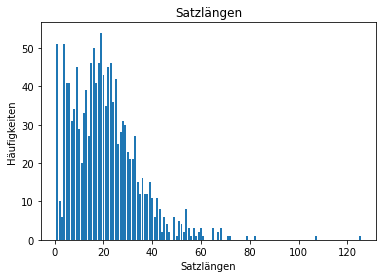

In [9]:
sents = []
for text, _ in train_data:
    doc = nlp(text)
    for sent in doc.sents:
        # find length by counting whitespaces in the sentence
        temp1 = sent.text
        temp2 = temp1.replace(' ', '')
        spaces = len(temp1) - len(temp2)
        sents.append(spaces+1)
# map lengths to amount of times it appereard
distribution = count_pos(sents)
plt.bar(list(distribution.keys()), list(distribution.values()))
plt.title("Satzlängen")
plt.xlabel("Satzlängen")
plt.ylabel("Häufigkeiten")
plt.show()

Welche Links (QSLinks, OLinks) werden von welchen Präpositionen (markiert durch SPATIAL_SIGNAL) getriggert (z.B. wie oft werden QSLinks durch die Präposition „on“ getriggert)?

In [10]:
qs_trigger = []
o_trigger = []

# collect all triggers
for data in full_data:
    temp_qs = []
    temp_o = []
    trigg_dic = {}
    
    # add all triggers ONLY with their id
    for elem in data[1]:
        if elem.tag == "QSLINK":
            temp_qs.append(elem.attrib['trigger'])
        elif elem.tag == "OLINK":
            temp_o.append(elem.attrib['trigger'])
        if elem.tag == "SPATIAL_SIGNAL":
            trigg_dic[elem.get('id')] = elem.get('text')

    # replace trigger id with their respective texts
    for i in range(len(temp_qs)):
        try:
            qs_trigger.append(trigg_dic[temp_qs[i]])
        except:
            pass
    for i in range(len(temp_o)):
        try:
            o_trigger.append(trigg_dic[temp_o[i]])
        except:
            pass

qs_trigger = count_pos(qs_trigger)
o_trigger = count_pos(o_trigger)

print("Aufgabe 5:")
print("\nQslink trigger:", *qs_trigger.items(), sep="\n")
print("\nOlink trigger:", *o_trigger.items(), sep="\n")

Aufgabe 5:

Qslink trigger:
('On', 4)
('In', 22)
('to', 2)
('bordering', 1)
('inside of', 1)
('covering', 1)
('overlooking', 2)
('on top of', 1)
('for', 1)
('about', 1)
('into', 1)
('inhabited', 1)
('beside', 1)
('up', 1)
('on', 75)
('Along', 1)
('over', 2)
('far from', 3)
('afar', 1)
('at', 54)
('after', 1)
('away from', 4)
('behind', 1)
('adjacent to', 1)
('apart', 1)
('through', 4)
('stocked', 1)
('part         of', 1)
('Down', 1)
('where', 68)
('between', 5)
('covered', 5)
('atop', 2)
('packed with', 1)
('across', 2)
('restricted', 1)
('line', 1)
('out of', 1)
('inside', 4)
('apart from', 1)
('connects', 4)
('upon', 1)
('house', 1)
('surmounted', 1)
('further', 1)
('with', 15)
('coiling up', 1)
('In front of', 1)
('up to', 1)
('next to', 10)
('has', 2)
('of', 44)
('around', 4)
('Everywhere', 1)
('from', 3)
('filled', 3)
('including', 3)
('directly beneath', 1)
('At', 6)
('surrounded', 2)
('contains', 1)
('along', 14)
('full of', 10)
('houses', 11)
('away', 2)
('in front of', 1)
('o

Welches sind die fünf häufigsten „MOTION“ Verben (und wie oft kommen diese vor)?

In [ ]:
lemma_verbs = []   # only collect lemma from verbs
for data in full_data:
    # collect all different motion verbs
    verbs = []  
    for elem in data[1]:
        if elem.tag == "MOTION":
            verbs.append(elem.attrib['text'])
            
    # only add their lemma to the actual list
    doc = nlp(data[0].text)
    for token in doc:
        if token.text in verbs:
            lemma_verbs.append(token.lemma_)

lemma_verbs = count_pos(lemma_verbs)
lemma_verbs = sorted(lemma_verbs.items(), key=lambda x: x[1], reverse=True)
print("Aufgabe 6:", *lemma_verbs[0:5], sep="\n")

## 2.4 Visualisierung

Graphische Darstellung von Verbindungen zwischen Entitäten

**Bicycle.xml**

In [ ]:
print(special1)

G = nx.Graph()
color_map = []
counter = 0
for elem in special1[1]:
     if elem.tag == "SPATIAL_ENTITY":
          G.add_node(elem.attrib['text'])

nx.draw(G, node_color='r', with_labels=True)

for elem in special1[1]:
     if elem.tag == "PLACE":
          G.add_node(elem.attrib['text'])

nx.draw(G, node_color='b', with_labels=True)


for elem in special1[1]:
     if elem.tag == "LOCATION":
          G.add_node(elem.attrib['text'])

nx.draw(G, node_color='g', with_labels=True)


for elem in special1[1]:
     if elem.tag == "PATH":
          G.add_node(elem.attrib['text'])

nx.draw(G, node_color='w', with_labels=True)


for elem in special1[1]:
     if elem.tag == "NONMOTIONEVENT":
          G.add_node(elem.attrib['text'])

nx.draw(G, node_color='y', with_labels=True)

**Highlights_of_the_Prado_Museum.xml**